In [1]:
import os
import argparse
from collections import OrderedDict
from collections import OrderedDict as OD
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval # hyperparameter optimization

parser = argparse.ArgumentParser()
parseGroup1 = parser.add_mutually_exclusive_group(required=True)
parseGroup1.add_argument('--ChunkyDonut',    action='store_true')
parseGroup1.add_argument('--PhiRing',        action='store_true')
parseGroup2 = parser.add_mutually_exclusive_group(required=True)
parseGroup2.add_argument('--l1MatchOffline', action='store_true')
parseGroup2.add_argument('--l1MatchGen',     action='store_true')

runLocally = True

args = None
if not runLocally:
    matplotlib.use('Agg') # use for condor jobs to disable display of plots
    args = parser.parse_args()
else:
    args = parser.parse_args("--ChunkyDonut --l1MatchGen".split()) # to run in jupyter-notebook     
l1Jet_ChunkyDonut = args.ChunkyDonut
l1Jet_PhiRing     = args.PhiRing
l1MatchOffline    = args.l1MatchOffline
l1MatchGen        = args.l1MatchGen

version         = "v6_test_MLPtBin0to25_25to35_35to60_60to90_90Abv_MLEtaBinsFine" 
sIpFileName     = "../data/L1T_Jet_MLInputs_Run3_QCD_Pt15to7000_PFA1p_CMSSW12_6_0_pre1_nVtxAll_20220925.csv"
sOpFileName_SFs = "../data/L1T_Jet_SFs_Run3_QCD_Pt15to7000_PFA1p_CMSSW12_6_0_pre1_nVtxAll_20220925_%s.csv" % (version)
sOutDir         = "./plots_%s" % (version)

printLevel = PrintLevel = 5
iEtaBins = [i for i in range(1, 42) if i!=29]
sL1JetEt_PUS_ChunkyDonut = 'L1JetEt_PUS_ChunkyDonut'
sL1JetEt_PUS_PhiRing     = 'L1JetEt_PUS_PhiRing'
sOfflineJetEt            = 'PFJetEtCorr'
sGenJetEt                = 'GenJetEt'
sL1JetTowerIEtaAbs       = 'L1JetTowerIEtaAbs'
L1JetPtThrsh             = 10.0 # GeV
L1JetPtMax               = 255.0 # GeV

NCompPtBins = 16 # 16 # No. of compressed pT bins
calibSF_L1JetPtRange = [15., 255., 1.] # [<lowest pT>,  <hightest pT>,  <pT bin width>] # pT range for SFs to read from Syed's SF.csv file
LUT_PtRange = [0., 255., 1.] # pT range for SFs for LUT
SF_forZeroPt = 1.0



sL1JetEt  = sL1JetEt_PUS_ChunkyDonut if l1Jet_ChunkyDonut else sL1JetEt_PUS_PhiRing
sRefJetEt = sOfflineJetEt if l1MatchOffline else sGenJetEt 

sOpFileName_SFs = sOpFileName_SFs.replace('.csv', '_%s.csv' % (sL1JetEt))
sOutDir = '%s_%s' % (sOutDir, sL1JetEt)


PT_CAT = OD()
PT_CAT['Ptlt25']   = [ 0,  15,   25]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt25To35'] = [25,  30,   35]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt35To60'] = [35,  55,   60]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt60To90'] = [60,  75,   90]  ## Low pT, turn-on threshold, high pT   #[60,  90,   90]
PT_CAT['Ptgt90']   = [90, 120, 9999]  ## Low pT, turn-on threshold, high pT

ETA_CAT = OD()
ETA_CAT['HBEF'] = [0.000, 5.210]  ## Whole detector, 1 - 41
ETA_CAT['HB']   = [0.000, 1.392]  ## Trigger towers  1 - 16
ETA_CAT['HE1']  = [1.392, 1.740]  ## Trigger towers 17 - 20
ETA_CAT['HE2a'] = [1.740, 2.322]  ## Trigger towers 21 - 25
ETA_CAT['HE2b'] = [2.322, 3.000]  ## Trigger towers 26 - 28
ETA_CAT['HF']   = [3.000, 5.210]  ## Trigger towers 30 - 41

IETA_CAT = OD()
IETA_CAT['HBEF'] = [ 1, 41]  ## Whole detector, 1 - 41
IETA_CAT['HB']   = [ 1, 16]  ## Trigger towers  1 - 16
IETA_CAT['HE1']  = [17, 20]  ## Trigger towers 17 - 20
IETA_CAT['HE2a'] = [21, 25]  ## Trigger towers 21 - 25
IETA_CAT['HE2b'] = [26, 28]  ## Trigger towers 26 - 28
IETA_CAT['HF']   = [30, 41]  ## Trigger towers 30 - 41

CaloToolMPEtaBinsMerge_forEtaCompressedLUT_2018 = OrderedDict([
    ( 0, [*range(1, 5+1)]),  # 0
    ( 1, [*range(6, 9+1)]),  # 1
    ( 2, [*range(10,13+1)]), # 2
    ( 3, [*range(14,15+1)]), # 3
    ( 4, [*range(16,17+1)]), # 4
    ( 5, [*range(18,19+1)]), # 5
    ( 6, [*range(20,21+1)]), # 6
    ( 7, [22]), # 7
    ( 8, [23]), # 8
    ( 9, [24]), # 9
    (10, [25]), # 10
    (11, [26]), # 11
    (12, [*range(27,28+1)]), # 12
    (13, [*range(29,31+1)]), # 13
    (14, [*range(32,35+1)]), # 14
    (15, [*range(36,40+1)]), # 15
])
CaloToolMPEtaBinsMerge_forEtaCompressedLUT = CaloToolMPEtaBinsMerge_forEtaCompressedLUT_2018

useAbsEtaBins = True
ETA_Bins = []
for iEta in range(-41,42):
    if iEta in [-29, 0, 29]:        continue;
    if useAbsEtaBins and iEta < 0:  continue;
    ETA_Bins.append(str(iEta))

map_CaloIEta_to_CaloTool_mpEta = OrderedDict([
    (1, 1),
    (2, 2),
    (3, 3),
    (4, 4),
    (5, 5),
    (6, 6),
    (7, 7),
    (8, 8),
    (9, 9),
    (10, 10),
    
    (11, 11),
    (12, 12),
    (13, 13),
    (14, 14),
    (15, 15),
    (16, 16),
    (17, 17),
    (18, 18),
    (19, 19),
    (20, 20),
    
    (21, 21),
    (22, 22),
    (23, 23),
    (24, 24),
    (25, 25),
    (26, 26),
    (27, 27),
    (28, 28),
    (29, 29),
    (30, 29),
    
    (31, 30),
    (32, 31),
    (33, 32),
    (34, 33),
    (35, 34),
    (36, 35),
    (37, 36),
    (38, 37),
    (39, 38),
    (40, 39),

    (41, 40),
])



data_all = pd.read_csv(sIpFileName)
print("Input file: %s" % (sIpFileName))
print("iEtaBins ({}): {}".format(len(iEtaBins), iEtaBins))
print("sRefJetEt: {}, \t sL1Jet: {}, \t L1JetPtThrsh: {}".format(sRefJetEt, sL1JetEt, L1JetPtThrsh))
print("l1Jet_ChunkyDonut {}, l1Jet_PhiRing {}, l1MatchOffline {}, l1MatchGen {}".format(
    l1Jet_ChunkyDonut, l1Jet_PhiRing, l1MatchOffline, l1MatchGen))

Input file: ../data/L1T_Jet_MLInputs_Run3_QCD_Pt15to7000_PFA1p_CMSSW12_6_0_pre1_nVtxAll_20220925.csv
iEtaBins (40): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
sRefJetEt: GenJetEt, 	 sL1Jet: L1JetEt_PUS_ChunkyDonut, 	 L1JetPtThrsh: 10.0
l1Jet_ChunkyDonut True, l1Jet_PhiRing False, l1MatchOffline False, l1MatchGen True


In [2]:
print("data_all.columns: {}, \ndata_all.shape: {}".format(data_all.columns, data_all.shape))

data_all.columns: Index(['runNumber', 'lumiSectionNumber', 'eventNumber', 'nVertexReco',
       'GenJetEt', 'nVertexGen', 'nMeanPUGen', 'L1JetType', 'L1JetDefault_Et',
       'L1JetTowerIEtaAbs', 'L1JetDefault_RawEt',
       'L1JetDefault_PUEt_ChunkyDonut', 'L1Jet9x9_RawEt',
       'L1Jet9x9_EtSum7PUTowers', 'L1Jet9x9_PUEt_ChunkyDonut'],
      dtype='object'), 
data_all.shape: (18218932, 15)


In [3]:
data_all[sL1JetEt_PUS_ChunkyDonut] = data_all['L1Jet9x9_RawEt'] - data_all['L1Jet9x9_PUEt_ChunkyDonut']

data_all[sL1JetEt_PUS_PhiRing]     = data_all['L1Jet9x9_RawEt'] - (data_all['L1Jet9x9_EtSum7PUTowers'] / 7.0 )

sL1JetEt_forML              = 'log_%s' % (sL1JetEt)
sRefJetEt_forML             = 'log_%s' % (sRefJetEt)
train_vars = [sL1JetTowerIEtaAbs, sL1JetEt_forML]
target_var = sRefJetEt_forML
print("\nsL1JetEt_forML: {}, sRefJetEt_forML: {}".format(sL1JetEt_forML, sRefJetEt_forML))
print("train_vars: {}, \ntarget_var: {}\n".format(train_vars, target_var))

def transform_JetEt_forML(series):
    series_new = np.log(series)
    return series_new;

def transform_back_JetEt_fromML(series):
    series_new = np.exp(series)
    return series_new;

def prepareDataframeForSFs(iEtaBinRange, PtRangeMin=L1JetPtThrsh, PtRangeMax=L1JetPtMax):
    dict_iEta_Et = OD([ (sL1JetTowerIEtaAbs, []), (sL1JetEt, []) ])
    for iEta in iEtaBinRange:
        list_pt      = np.arange(PtRangeMin, PtRangeMax+1.0)
        list_ietabin = [iEta] * len(list_pt)
        dict_iEta_Et[sL1JetTowerIEtaAbs].extend(list_ietabin) 
        dict_iEta_Et[sL1JetEt].extend(list_pt) 
          
    data_SFs = pd.DataFrame(dict_iEta_Et)
    data_SFs[sL1JetEt_forML]    = transform_JetEt_forML(data_SFs[sL1JetEt])
    return data_SFs

data_all[sL1JetEt_forML]    = transform_JetEt_forML(data_all[sL1JetEt])
data_all[sRefJetEt_forML]   = transform_JetEt_forML(data_all[sRefJetEt])

if printLevel >= 1:
    print("data_all.describe(): \n{}".format(data_all.describe()))
#print("\n\ndata_SFs.describe(): \n{}".format(data_SFs.describe()))
#print("\n\ndata_SFs.describe(): \n{}".format(data_SFs.to_string()))


sL1JetEt_forML: log_L1JetEt_PUS_ChunkyDonut, sRefJetEt_forML: log_GenJetEt
train_vars: ['L1JetTowerIEtaAbs', 'log_L1JetEt_PUS_ChunkyDonut'], 
target_var: log_GenJetEt

data_all.describe(): 
        runNumber  lumiSectionNumber   eventNumber   nVertexReco  \
count  18218932.0       1.821893e+07  1.821893e+07  1.821893e+07   
mean          1.0       1.444852e+04  4.912329e+06  4.917846e+01   
std           0.0       8.523267e+03  2.897911e+06  9.442895e+00   
min           1.0       2.000000e+00  3.410000e+02  0.000000e+00   
25%           1.0       7.160000e+03  2.434180e+06  4.300000e+01   
50%           1.0       1.414000e+04  4.807572e+06  5.000000e+01   
75%           1.0       2.187400e+04  7.436836e+06  5.600000e+01   
max           1.0       2.941200e+04  1.000000e+07  9.200000e+01   

           GenJetEt    nVertexGen    nMeanPUGen  L1JetDefault_Et  \
count  1.821893e+07  1.821893e+07  1.821893e+07     1.821893e+07   
mean   1.386184e+02  4.975521e+01  4.917846e+01     1.378540

In [4]:
## data cleaning--------

# Drop entries with L1JetEt < L1JetPtThrsh
data_all_L1EtBelowThrsh = data_all[ data_all[sL1JetEt] < L1JetPtThrsh ]
if printLevel >= 6:
    print("data_all[ data_all['{}'] < {} ]: \n{}".format(sL1JetEt, L1JetPtThrsh, data_all_L1EtBelowThrsh))
data_all.drop(index=data_all_L1EtBelowThrsh.index, inplace=True)

print("\nDoes any of the columns have NaN entries: \ndata_all.isna().sum(): \n{}".format(data_all.isna().sum()))
if printLevel >= 5:
    print("\nAfter cleaning, data_all.describe(): \n{}".format(data_all.describe()))


Does any of the columns have NaN entries: 
data_all.isna().sum(): 
runNumber                        0
lumiSectionNumber                0
eventNumber                      0
nVertexReco                      0
GenJetEt                         0
nVertexGen                       0
nMeanPUGen                       0
L1JetType                        0
L1JetDefault_Et                  0
L1JetTowerIEtaAbs                0
L1JetDefault_RawEt               0
L1JetDefault_PUEt_ChunkyDonut    0
L1Jet9x9_RawEt                   0
L1Jet9x9_EtSum7PUTowers          0
L1Jet9x9_PUEt_ChunkyDonut        0
L1JetEt_PUS_ChunkyDonut          0
L1JetEt_PUS_PhiRing              0
log_L1JetEt_PUS_ChunkyDonut      0
log_GenJetEt                     0
dtype: int64

After cleaning, data_all.describe(): 
        runNumber  lumiSectionNumber   eventNumber   nVertexReco  \
count  17460754.0       1.746075e+07  1.746075e+07  1.746075e+07   
mean          1.0       1.444830e+04  4.912254e+06  4.917282e+01   
std        

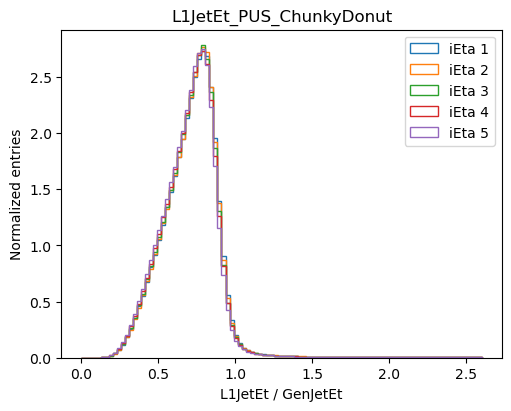

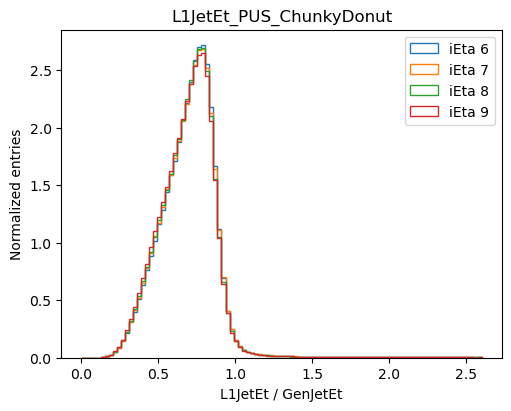

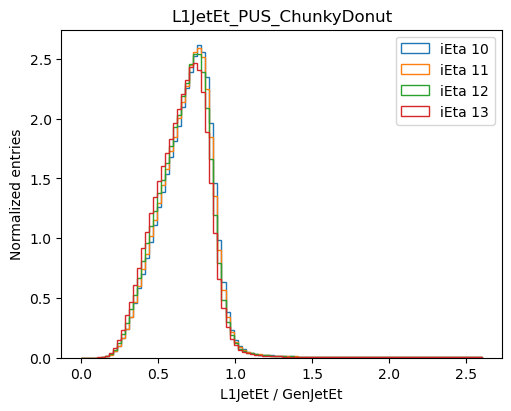

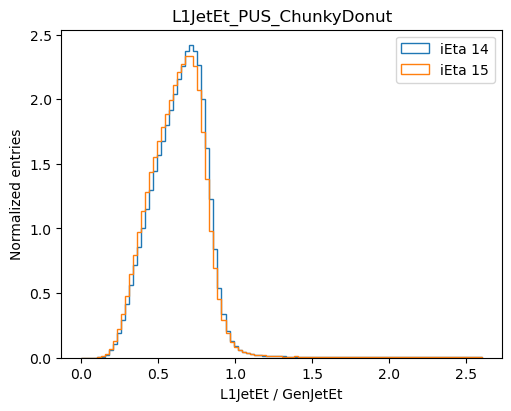

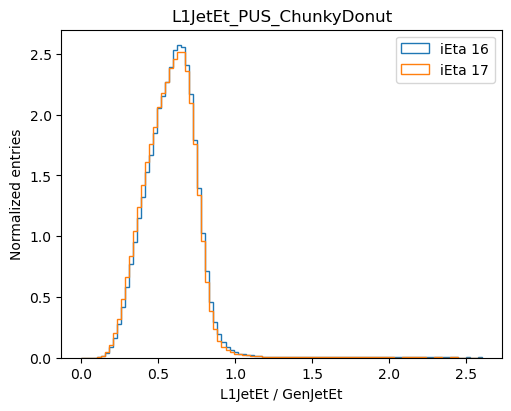

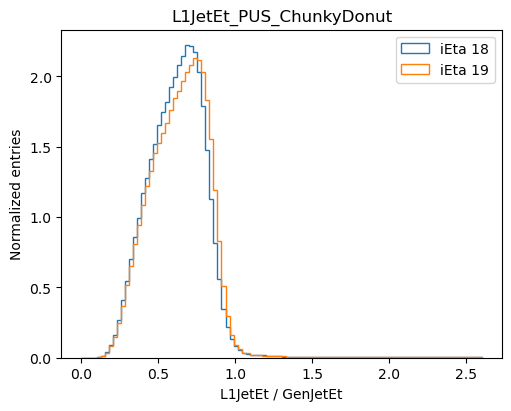

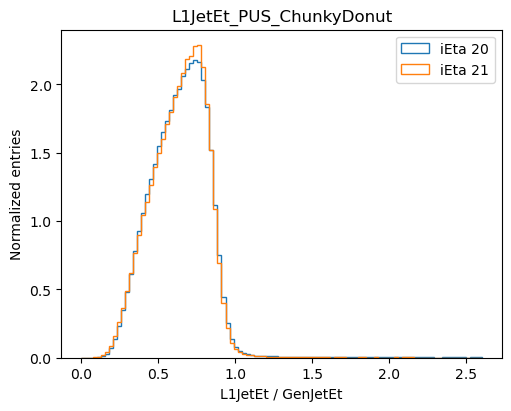

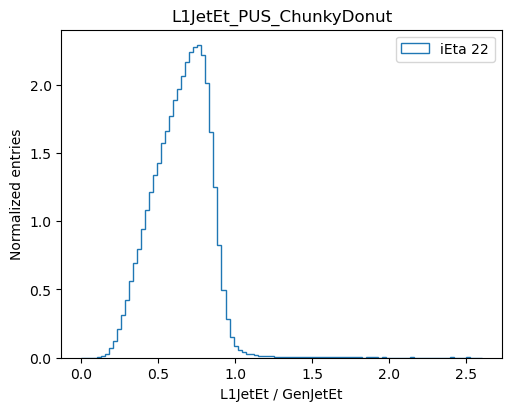

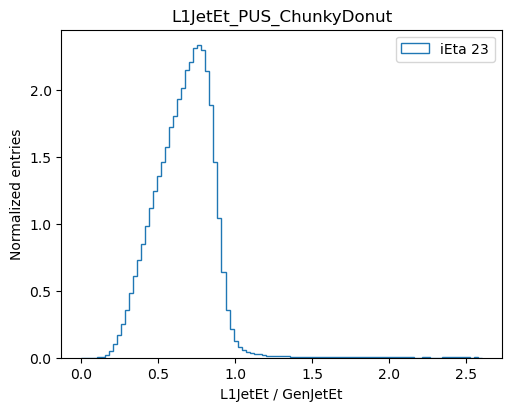

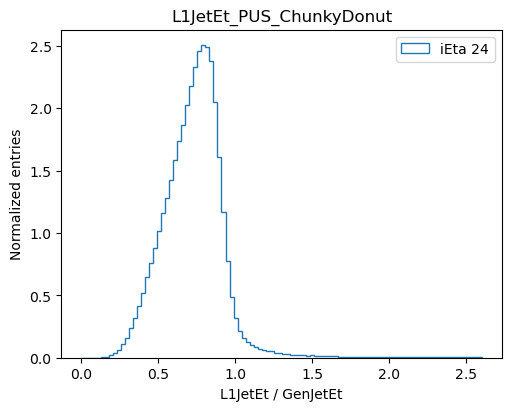

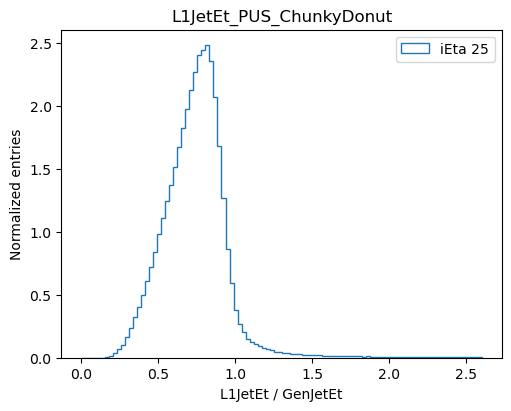

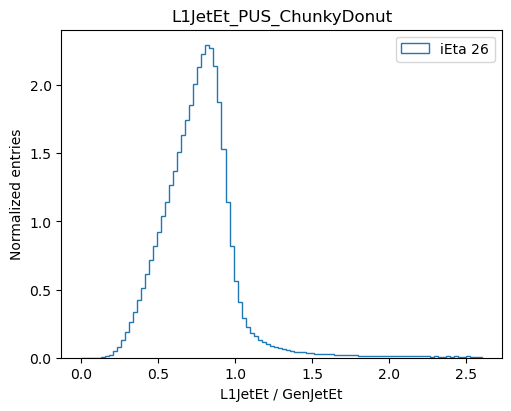

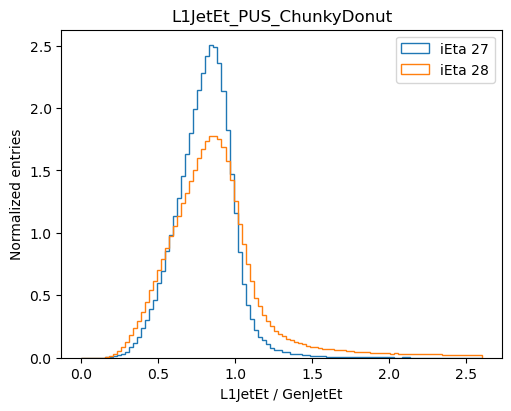

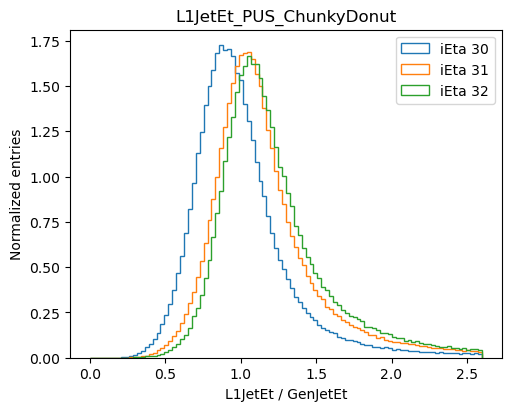

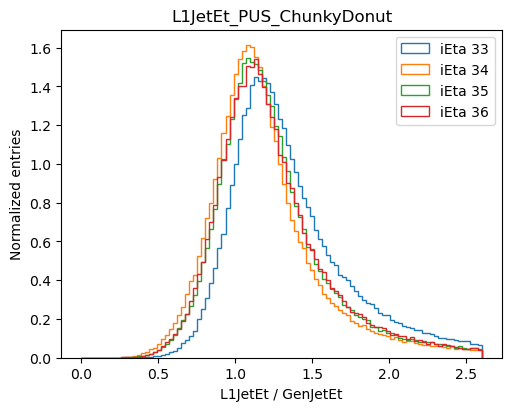

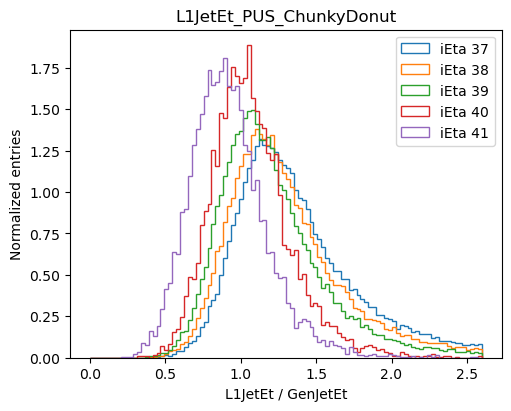

In [5]:
## make resolution plots before JEC

if not os.path.exists(sOutDir): 
    os.makedirs(sOutDir)
    
def convert_CaloToolMPEta_to_IEta(CaloToolMPEta):
    IEta = None
    for IEta_tmp in map_CaloIEta_to_CaloTool_mpEta.keys():
        if map_CaloIEta_to_CaloTool_mpEta[ IEta_tmp ] == CaloToolMPEta:
            IEta = IEta_tmp

    return IEta

#print("".format())
for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    
    for CaloTool_mpEta in CaloToolMPEtaRange: # runs each iEta in iEtaBinRange
        iEtaBin = convert_CaloToolMPEta_to_IEta(CaloTool_mpEta)
        data_all_iEtaBin = data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin]
        axs.hist(
            (data_all_iEtaBin[sL1JetEt]/data_all_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='iEta %d' % (iEtaBin),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s' % (sL1JetEt))
    axs.legend()
        
    fig.savefig('%s/beforeJEC_%s_ieta_%d_to_%d.png' % (sOutDir, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))
        


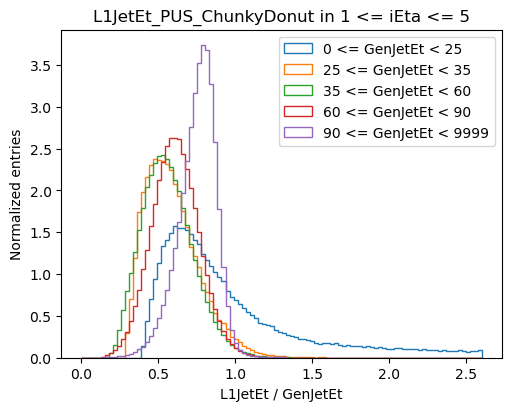

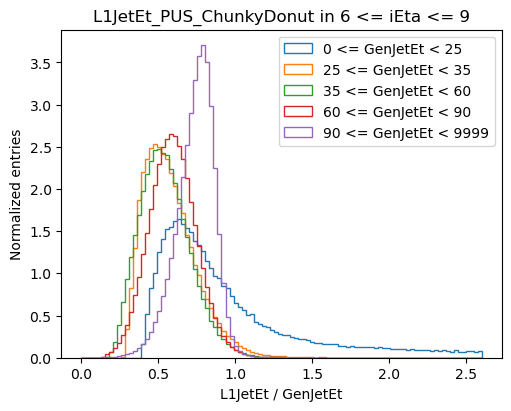

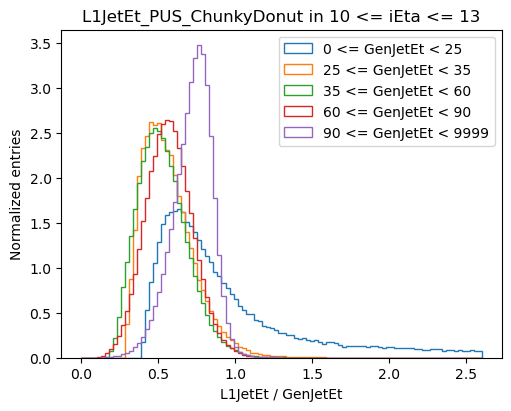

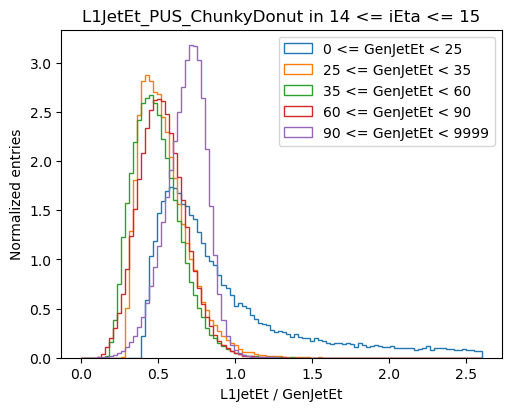

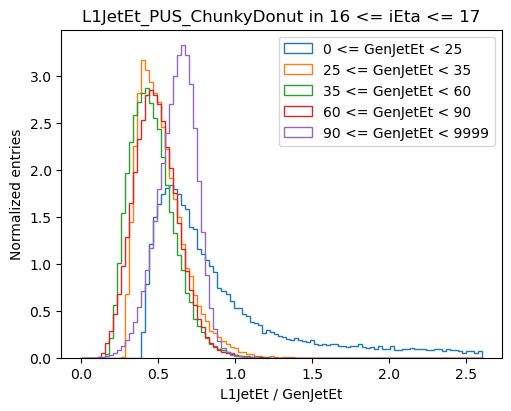

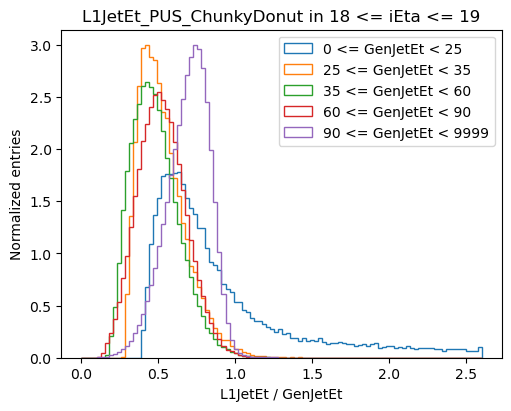

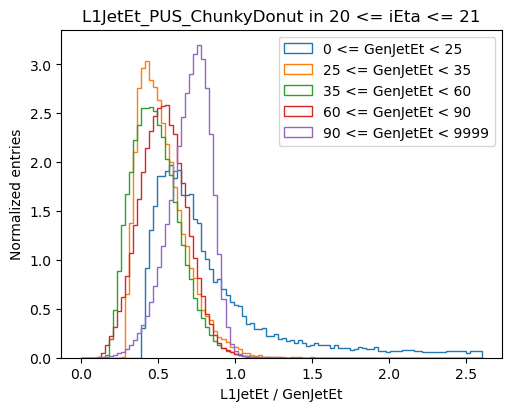

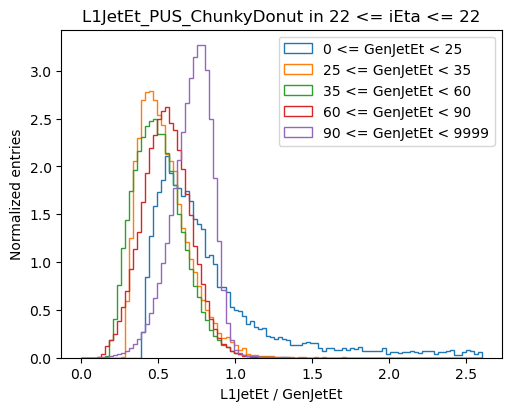

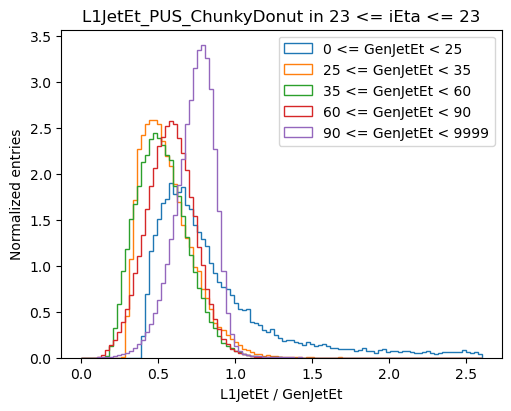

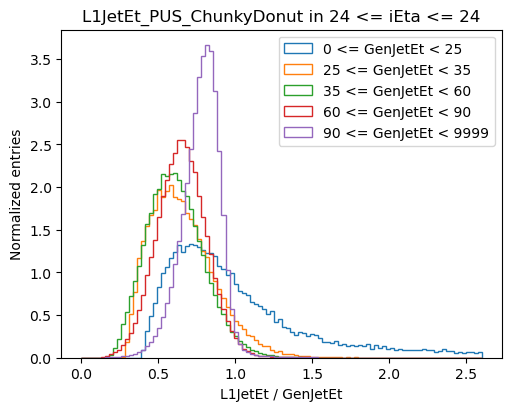

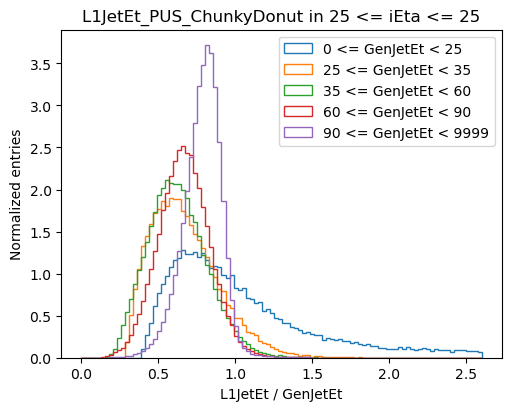

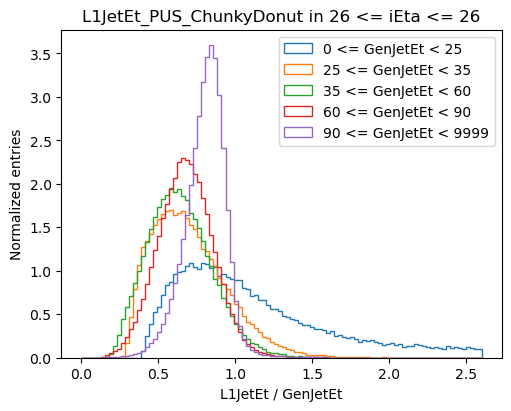

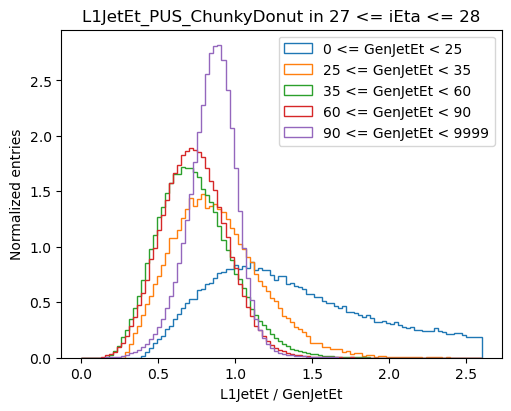

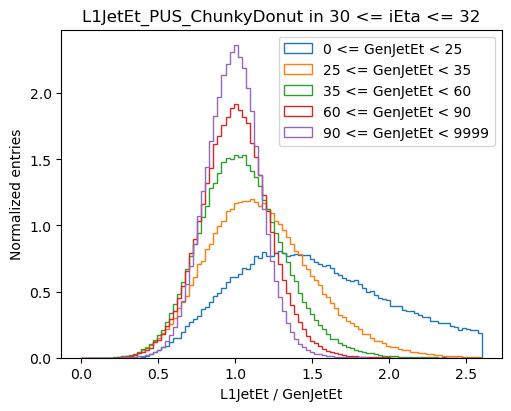

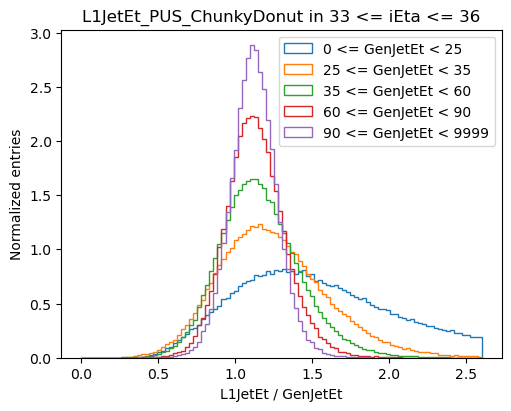

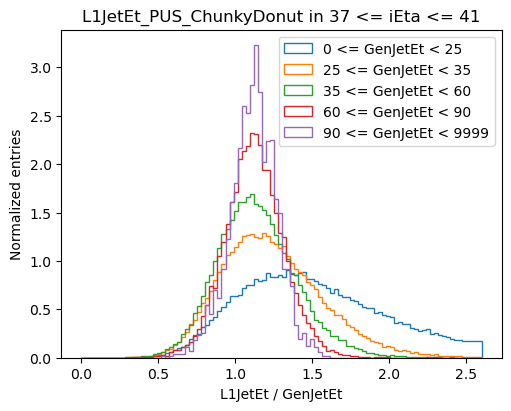

In [6]:
for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    iEtaBin_first = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0])
    iEtaBin_last  = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])
    
    for pt_cat, pt_range in PT_CAT.items(): 
        data_all_iEtaBin = data_all[
            (data_all[sL1JetTowerIEtaAbs] >= iEtaBin_first) &  
            (data_all[sL1JetTowerIEtaAbs] <= iEtaBin_last) & 
            (data_all[sRefJetEt] >= pt_range[0]) &
            (data_all[sRefJetEt] <  pt_range[2])
        ]
        axs.hist(
            (data_all_iEtaBin[sL1JetEt]/data_all_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='%d <= %s < %d' % (pt_range[0], sRefJetEt, pt_range[2]),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
    axs.legend()
        
    fig.savefig('%s/beforeJEC_%s_ieta_%d_to_%d_inPtCat.png' % (sOutDir, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))
        


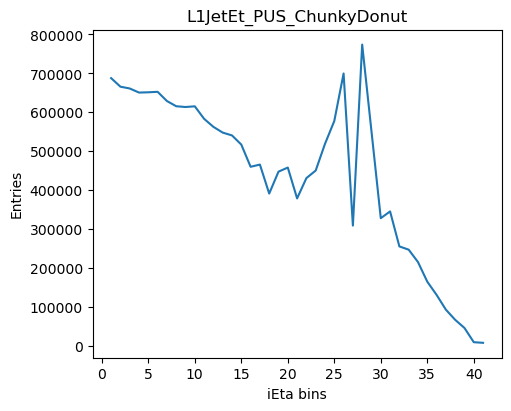

In [7]:
nEntriesPerIEtaBin = [len(data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin].index) for iEtaBin in iEtaBins]   
nEntriesPerIEtaBin_1 = { iEtaBin: len(data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin].index) for iEtaBin in iEtaBins}   
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
axs.plot(iEtaBins, nEntriesPerIEtaBin)
axs.set_xlabel('iEta bins')
axs.set_ylabel('Entries')
axs.set_title('%s' % (sL1JetEt))
#axs.legend()
fig.savefig('%s/%s_nEntriesPerIEtaBin.png' % (sOutDir, sL1JetEt))
if printLevel >= 11:
    print("nEntriesPerIEtaBin: {}".format(nEntriesPerIEtaBin))
    print("nEntriesPerIEtaBin_1: {}".format(nEntriesPerIEtaBin_1))
    
#nEntriesPerIEtaBinPtBin = []


In [8]:
#%%time

sL1JetEt_forML_predict = "%s_predict" % (sL1JetEt_forML)
sL1JetEt_predict       = "%s_predict" % (sL1JetEt)
sSF                    = "SF"

IEta_Cat_forML = OD()
IEta_Cat_forML['HB'] = [ 1, 16]
IEta_Cat_forML['HE12a'] = [17, 26]
IEta_Cat_forML['HE2b'] = [27, 28]
IEta_Cat_forML['HF30to32'] = [30, 32]
IEta_Cat_forML['HF33to36'] = [33, 36]
IEta_Cat_forML['HF37to41'] = [37, 41]
#IEta_Cat['HBEF'] = [ 1, 41]

Pt_Cat_forML = OD()
#Pt_Cat_forML['Ptlt60'] = [ 0, 60]
#Pt_Cat_forML['Ptgt60'] = [60, L1JetPtMax]
Pt_Cat_forML['Ptlt25']   = [ 0, 25]
Pt_Cat_forML['Pt25to35'] = [25, 35]
Pt_Cat_forML['Pt35to60'] = [35, 60]
Pt_Cat_forML['Pt60to90'] = [60, 90]
Pt_Cat_forML['Ptgt90']   = [90, L1JetPtMax]

if printLevel >= 11:
    print("train_vars: {}, \ntarget_var: {}, \nsL1JetEt_forML_predict: {}, \nsL1JetEt_predict: {}, \nsSF: {}".format(
        train_vars, target_var, sL1JetEt_forML_predict, sL1JetEt_predict, sSF))
    
varsOfInterest = train_vars.copy()
varsOfInterest.extend([target_var, sL1JetEt, sRefJetEt])
if printLevel >= 0:
    print("Going for BDT training: varsOfInterest: {}\n".format(varsOfInterest))
    print("After train_vars: {}, \ntarget_var: {}, \nsL1JetEt_forML_predict: {}, \nsL1JetEt_predict: {}, \nsSF: {}".format(
        train_vars, target_var, sL1JetEt_forML_predict, sL1JetEt_predict, sSF))

# ML training ----------------------------------------------------------------------
def train_MLModel_wHyperopt(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
    
    hyperparameter_space = { 
        #'n_estimators': hp.choice('n_estimators', np.arange(500, 2001, 100, dtype=int)),
        'n_estimators': hp.choice('n_estimators', np.arange(700, 701, 100, dtype=int)),
        #'learning_rate':hp.quniform('learning_rate', 0.01, 0.2, 0.01),
        'learning_rate':hp.quniform('learning_rate', 0.05, 0.055, 0.01),
        'early_stopping_rounds': 10
    }    
    max_evals = 1 # 30
    
    def ML_score(params):
        model = XGBRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False       
        )
        score = mean_squared_error(y_valid, model.predict(X_valid), squared=False)
        if printLevel >= 3:
            print("score: valid {}, train {}. params: {}".format(
                score,
                mean_squared_error(y_train, model.predict(X_train), squared=False),
                params))
        return {'loss': score, 'status': STATUS_OK, 'ML_model': model}
            
    
    def getBestMLModel(trials):
        # https://stackoverflow.com/questions/54273199/how-to-save-the-best-hyperopt-optimized-keras-models-and-its-weights
        valid_trial_list = [trial for trial in trials  if STATUS_OK == trial['result']['status']]
        losses = [float(trial['result']['loss']) for trial in valid_trial_list]
        index_having_minimum_loss = np.argmin(losses)
        best_trial_obj = valid_trial_list[index_having_minimum_loss]
        return best_trial_obj['result']['ML_model']
        
        
        
    # ref: 
    # https://sites.google.com/view/raybellwaves/blog/using-xgboost-and-hyperopt-in-a-kaggle-comp
    # https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook
    trials = Trials()
    best_params = fmin(
        fn=ML_score,
        space=hyperparameter_space, 
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials)
    print("best_params: {}".format(best_params))
    print("space_eval(hyperparameter_space, best_params): {}".format(space_eval(hyperparameter_space, best_params)))
    
    return getBestMLModel(trials)
# ----------------------------------------------------------------------------        
    
    
    
    
    
data_SFs = None
for iEta_category, iEtaBinRange in IEta_Cat_forML.items():
    iEtaBins_i = range(iEtaBinRange[0], iEtaBinRange[-1]+1)

    for Pt_category, PtRange in Pt_Cat_forML.items():
        PtRangeMin = PtRange[0]
        PtRangeMax = PtRange[1]
        
        data_all_iEtaBins = data_all[
            (data_all[sL1JetTowerIEtaAbs] >= iEtaBinRange[0]) & 
            (data_all[sL1JetTowerIEtaAbs] <= iEtaBinRange[-1]) &
            (data_all[sL1JetEt] >= PtRangeMin) &
            (data_all[sL1JetEt] <  PtRangeMax)
        ][varsOfInterest]
        if printLevel >= 0:
            print("\niEta_category {}, iEtaBinRange {}, Pt_category {}, PtRange {}, data_all_iEtaBins.describe(): \n{}".format(
                iEta_category, iEtaBinRange, Pt_category, PtRange, data_all_iEtaBins.describe()))


        X = data_all_iEtaBins[train_vars]
        y = data_all_iEtaBins[target_var]

        xgb_rg = train_MLModel_wHyperopt(X, y)


        data_SFs_i = prepareDataframeForSFs(iEtaBins_i, PtRangeMin=PtRangeMin, PtRangeMax=PtRangeMax)
        data_SFs_i[sL1JetEt_forML_predict] = xgb_rg.predict(data_SFs_i[train_vars])
        data_SFs_i[sL1JetEt_predict]       = transform_back_JetEt_fromML( data_SFs_i[sL1JetEt_forML_predict] )
        data_SFs_i[sSF]                    = data_SFs_i[sL1JetEt_predict] / data_SFs_i[sL1JetEt]
        if printLevel >= 11:
            print("iEtaBins_i: {}".format(iEtaBins_i))
            print("data_SFs_i: {}".format(data_SFs_i.describe()))

        if data_SFs is None:
            data_SFs = data_SFs_i
        else:
            data_SFs = pd.concat([data_SFs, data_SFs_i])    

    
    
#print("Hello1")    
#print("\n\ndata_SFs: \n{}".format(data_SFs.to_string()))
data_SFs.to_csv(sOpFileName_SFs, index=False)
print("Wrote {}".format(sOpFileName_SFs))

Going for BDT training: varsOfInterest: ['L1JetTowerIEtaAbs', 'log_L1JetEt_PUS_ChunkyDonut', 'log_GenJetEt', 'L1JetEt_PUS_ChunkyDonut', 'GenJetEt']

After train_vars: ['L1JetTowerIEtaAbs', 'log_L1JetEt_PUS_ChunkyDonut'], 
target_var: log_GenJetEt, 
sL1JetEt_forML_predict: log_L1JetEt_PUS_ChunkyDonut_predict, 
sL1JetEt_predict: L1JetEt_PUS_ChunkyDonut_predict, 
sSF: SF

iEta_category HB, iEtaBinRange [1, 16], Pt_category Ptlt25, PtRange [0, 25], data_all_iEtaBins.describe(): 
       L1JetTowerIEtaAbs  log_L1JetEt_PUS_ChunkyDonut  log_GenJetEt  \
count       1.547785e+06                 1.547785e+06  1.547785e+06   
mean        8.278287e+00                 2.805484e+00  3.453590e+00   
std         4.579825e+00                 2.594091e-01  5.681608e-01   
min         1.000000e+00                 2.302585e+00  1.098631e+00   
25%         4.000000e+00                 2.602690e+00  3.241357e+00   
50%         8.000000e+00                 2.833213e+00  3.565192e+00   
75%         1.200000e+0

/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



iEta_category HB, iEtaBinRange [1, 16], Pt_category Pt25to35, PtRange [25, 35], data_all_iEtaBins.describe(): 
       L1JetTowerIEtaAbs  log_L1JetEt_PUS_ChunkyDonut   log_GenJetEt  \
count      805276.000000                805276.000000  805276.000000   
mean            8.256742                     3.381213       3.992999   
std             4.582774                     0.097764       0.307835   
min             1.000000                     3.218876       1.099437   
25%             4.000000                     3.295837       3.832952   
50%             8.000000                     3.384390       4.011426   
75%            12.000000                     3.465736       4.180116   
max            16.000000                     3.540959       6.431264   

       L1JetEt_PUS_ChunkyDonut       GenJetEt  
count            805276.000000  805276.000000  
mean                 29.547011      56.550014  
std                   2.881415      15.886129  
min                  25.000000       3.002475  

score: valid 0.49419631382888723, train 0.4940603538997331. params: {'early_stopping_rounds': 10, 'learning_rate': 0.05, 'n_estimators': 700}                                                                                                                                   
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:27<00:00, 27.96s/trial, best loss: 0.49419631382888723]
best_params: {'learning_rate': 0.05, 'n_estimators': 0}
space_eval(hyperparameter_space, best_params): {'early_stopping_rounds': 10, 'learning_rate': 0.05, 'n_estimators': 700}


/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



iEta_category HE12a, iEtaBinRange [17, 26], Pt_category Pt25to35, PtRange [25, 35], data_all_iEtaBins.describe(): 
       L1JetTowerIEtaAbs  log_L1JetEt_PUS_ChunkyDonut   log_GenJetEt  \
count      497246.000000                497246.000000  497246.000000   
mean           22.166986                     3.380523       3.955168   
std             3.016697                     0.097662       0.371012   
min            17.000000                     3.218876       1.099211   
25%            20.000000                     3.295837       3.786035   
50%            23.000000                     3.384390       3.992671   
75%            25.000000                     3.465736       4.180557   
max            26.000000                     3.540959       6.059800   

       L1JetEt_PUS_ChunkyDonut       GenJetEt  
count            497246.000000  497246.000000  
mean                 29.526364      55.296279  
std                   2.877650      17.346584  
min                  25.000000       3.0017

score: valid 0.7417027405975167, train 0.7395493538914214. params: {'early_stopping_rounds': 10, 'learning_rate': 0.05, 'n_estimators': 700}                                                                                                                                    
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.11s/trial, best loss: 0.7417027405975167]
best_params: {'learning_rate': 0.05, 'n_estimators': 0}
space_eval(hyperparameter_space, best_params): {'early_stopping_rounds': 10, 'learning_rate': 0.05, 'n_estimators': 700}

iEta_category HE2b, iEtaBinRange [27, 28], Pt_category Pt25to35, PtRange [25, 35], data_all_iEtaBins.describe(): 
       L1JetTowerIEtaAbs  log_L1JetEt_PUS_ChunkyDonut   log_GenJetEt  \
count      149444.000000                149444.000000  149444.000000   
mean           27.

/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


score: valid 0.6241039445270304, train 0.6243217012803044. params: {'early_stopping_rounds': 10, 'learning_rate': 0.05, 'n_estimators': 700}                                                                                                                                    
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.37s/trial, best loss: 0.6241039445270304]
best_params: {'learning_rate': 0.05, 'n_estimators': 0}
space_eval(hyperparameter_space, best_params): {'early_stopping_rounds': 10, 'learning_rate': 0.05, 'n_estimators': 700}

iEta_category HE2b, iEtaBinRange [27, 28], Pt_category Pt35to60, PtRange [35, 60], data_all_iEtaBins.describe(): 
       L1JetTowerIEtaAbs  log_L1JetEt_PUS_ChunkyDonut   log_GenJetEt  \
count      238374.000000                238374.000000  238374.000000   
mean           27.

/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


score: valid 0.5779069410248722, train 0.5790245279743483. params: {'early_stopping_rounds': 10, 'learning_rate': 0.05, 'n_estimators': 700}                                                                                                                                    
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.13s/trial, best loss: 0.5779069410248722]
best_params: {'learning_rate': 0.05, 'n_estimators': 0}
space_eval(hyperparameter_space, best_params): {'early_stopping_rounds': 10, 'learning_rate': 0.05, 'n_estimators': 700}

iEta_category HF30to32, iEtaBinRange [30, 32], Pt_category Pt35to60, PtRange [35, 60], data_all_iEtaBins.describe(): 
       L1JetTowerIEtaAbs  log_L1JetEt_PUS_ChunkyDonut   log_GenJetEt  \
count      296746.000000                296746.000000  296746.000000   
mean          

/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



iEta_category HF33to36, iEtaBinRange [33, 36], Pt_category Pt25to35, PtRange [25, 35], data_all_iEtaBins.describe(): 
       L1JetTowerIEtaAbs  log_L1JetEt_PUS_ChunkyDonut   log_GenJetEt  \
count      148696.000000                148696.000000  148696.000000   
mean           34.406924                     3.391069       3.018065   
std             1.072959                     0.096437       0.560738   
min            33.000000                     3.218876       1.098649   
25%            34.000000                     3.314186       2.826400   
50%            34.000000                     3.401197       3.158292   
75%            35.000000                     3.481240       3.390108   
max            36.000000                     3.540959       4.456268   

       L1JetEt_PUS_ChunkyDonut       GenJetEt  
count            148696.000000  148696.000000  
mean                 29.835281      23.150707  
std                   2.853375       9.731012  
min                  25.000000       3.0

score: valid 0.4741281275091996, train 0.4667685055993923. params: {'early_stopping_rounds': 10, 'learning_rate': 0.05, 'n_estimators': 700}                                                                                                                                    
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56trial/s, best loss: 0.4741281275091996]
best_params: {'learning_rate': 0.05, 'n_estimators': 0}
space_eval(hyperparameter_space, best_params): {'early_stopping_rounds': 10, 'learning_rate': 0.05, 'n_estimators': 700}

iEta_category HF37to41, iEtaBinRange [37, 41], Pt_category Pt25to35, PtRange [25, 35], data_all_iEtaBins.describe(): 
       L1JetTowerIEtaAbs  log_L1JetEt_PUS_ChunkyDonut  log_GenJetEt  \
count       57827.000000                 57827.000000  57827.000000   
mean           3

/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


score: valid 0.4866236937422738, train 0.4777905022078909. params: {'early_stopping_rounds': 10, 'learning_rate': 0.05, 'n_estimators': 700}                                                                                                                                    
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/trial, best loss: 0.4866236937422738]
best_params: {'learning_rate': 0.05, 'n_estimators': 0}
space_eval(hyperparameter_space, best_params): {'early_stopping_rounds': 10, 'learning_rate': 0.05, 'n_estimators': 700}

iEta_category HF37to41, iEtaBinRange [37, 41], Pt_category Pt35to60, PtRange [35, 60], data_all_iEtaBins.describe(): 
       L1JetTowerIEtaAbs  log_L1JetEt_PUS_ChunkyDonut  log_GenJetEt  \
count       97018.000000                 97018.000000  97018.000000   
mean           3

In [9]:
sL1JetEt_calib = '%s_calib' % (sL1JetEt)
data_copy1     = data_all[[sL1JetTowerIEtaAbs, sL1JetEt, sGenJetEt]].copy()
data_SFs_copy1 = data_SFs[[sL1JetTowerIEtaAbs, sL1JetEt, sSF]].copy()
data_SFs_copy1 = data_SFs_copy1.set_index([sL1JetTowerIEtaAbs, sL1JetEt])
SFs_dict       = data_SFs_copy1.to_dict()[sSF]

def calibrateJet(Et_0, iEta):
    Et = round(Et_0)
    if Et < calibSF_L1JetPtRange[0]: Et = round(calibSF_L1JetPtRange[0])
    if Et > calibSF_L1JetPtRange[1]: Et = round(calibSF_L1JetPtRange[1])
    #print(f"iEta {iEta}, Et {Et}")
    sf = SFs_dict[(iEta, Et)] if Et >= 1 else SF_forZeroPt
    return Et_0 * sf

data_copy1[sL1JetEt_calib] = data_copy1.apply(lambda row: calibrateJet(row[sL1JetEt], row[sL1JetTowerIEtaAbs]), axis=1)
#data_copy1[sL1JetEt_calib] = np.vectorize(calibrateJet)(data_copy1[sL1JetEt], data_copy1[sL1JetTowerIEtaAbs])
if printLevel >= 10:
    print("data_copy1: {}".format(data_copy1))

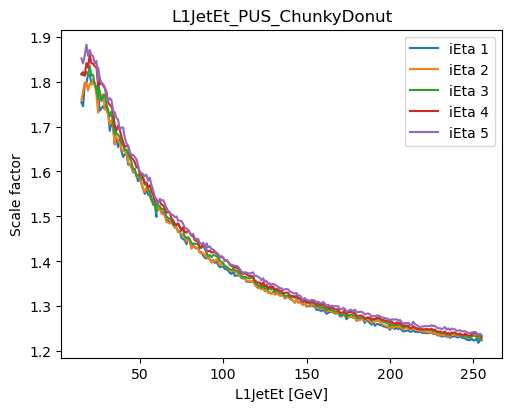

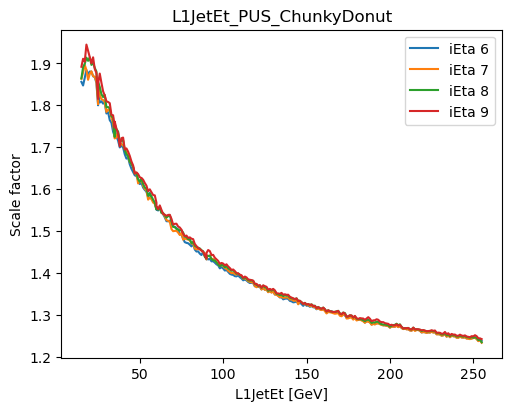

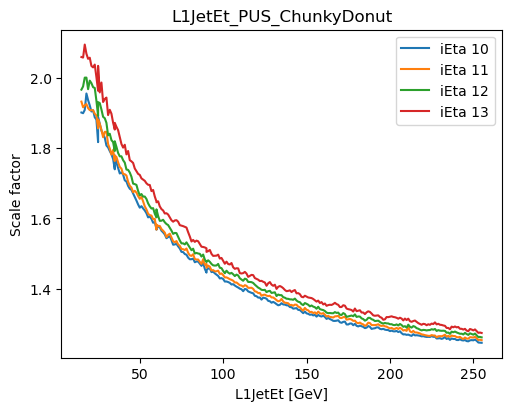

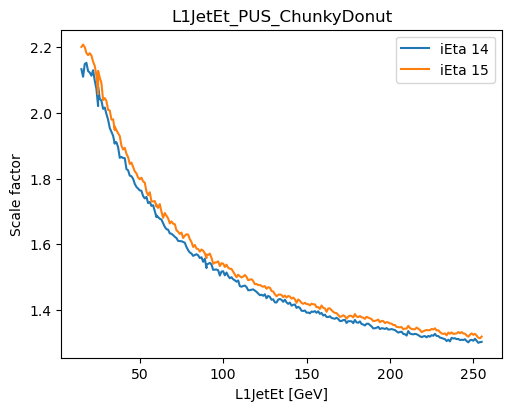

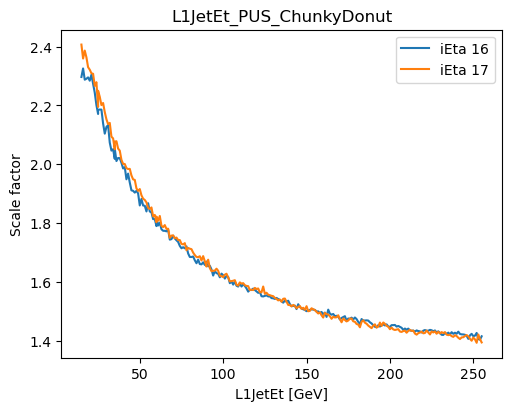

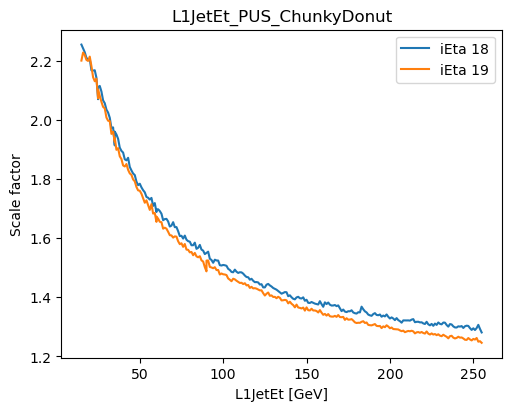

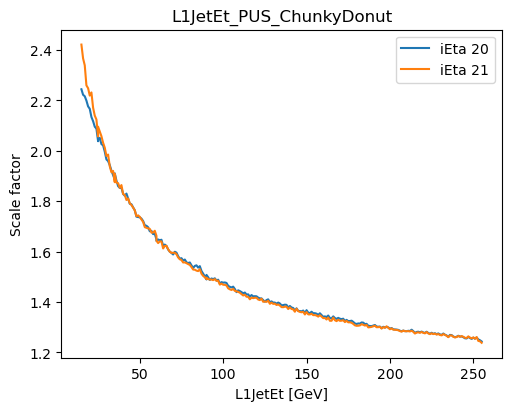

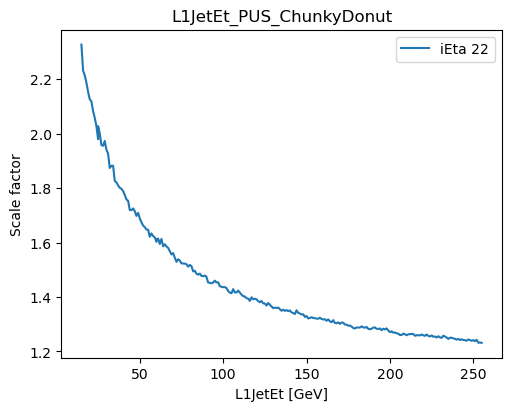

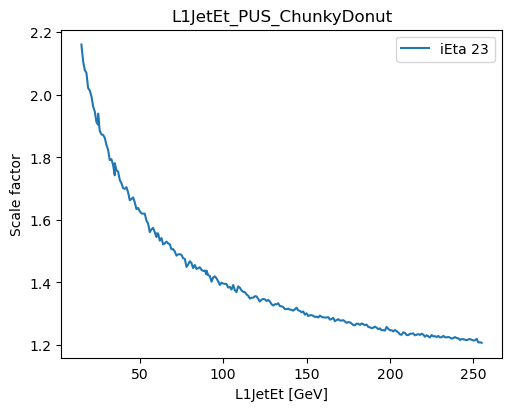

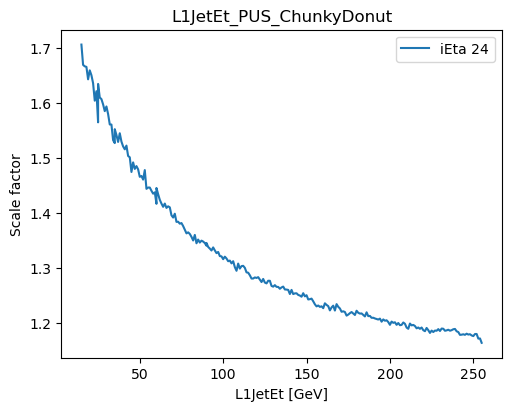

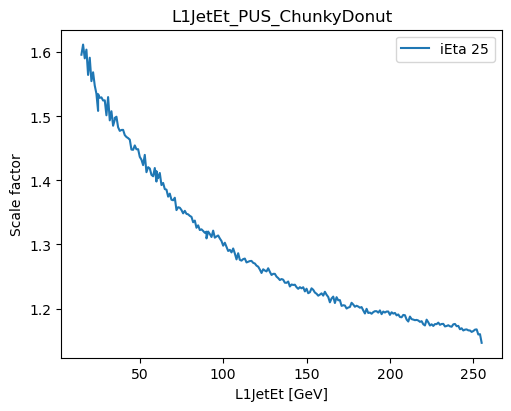

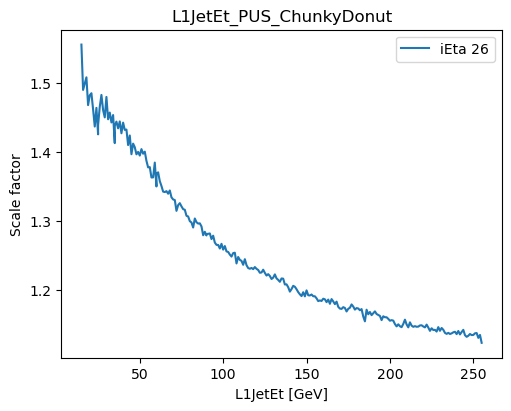

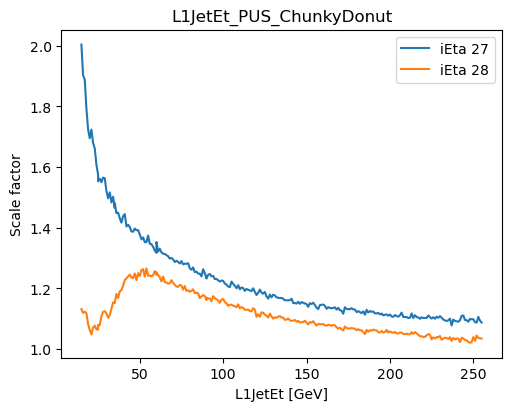

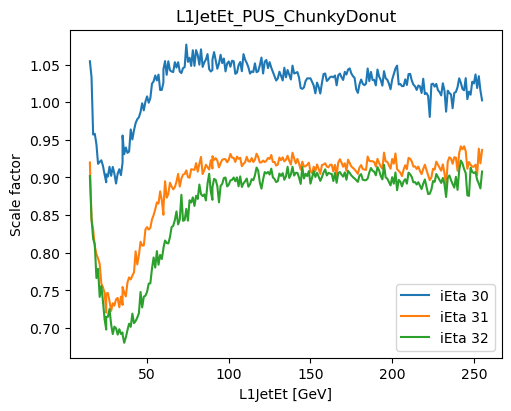

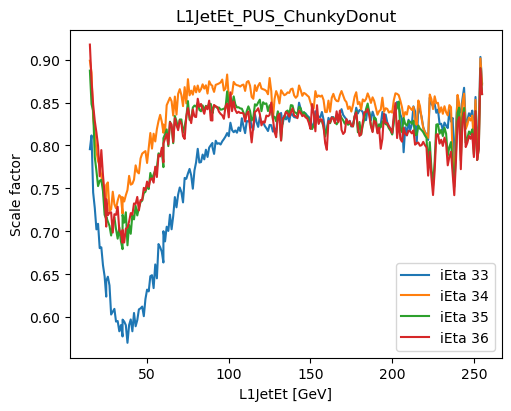

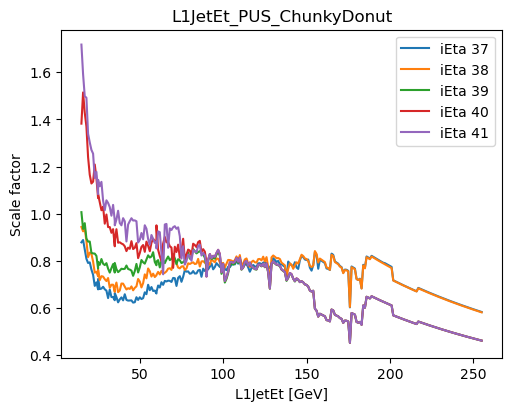

In [10]:
# SF vs Et plots ----
for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    
    for CaloTool_mpEta in CaloToolMPEtaRange: # runs each iEta in iEtaBinRange
        iEtaBin = convert_CaloToolMPEta_to_IEta(CaloTool_mpEta)
        data_SFs_iEtaBin = data_SFs[
            (data_SFs[sL1JetTowerIEtaAbs] == iEtaBin) & 
            (data_SFs[sL1JetEt] >=  calibSF_L1JetPtRange[0])
        ].copy()
        axs.plot(
            data_SFs_iEtaBin[sL1JetEt],
            data_SFs_iEtaBin[sSF],
            label='iEta %d' % (iEtaBin)
        )
    axs.set_xlabel('L1JetEt [GeV]')
    axs.set_ylabel('Scale factor')
    axs.set_title('%s' % (sL1JetEt))
    axs.legend()
        
    fig.savefig('%s/SF_vs_Et_%s_ieta_%d_to_%d.png' % (sOutDir, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))
 



Done.


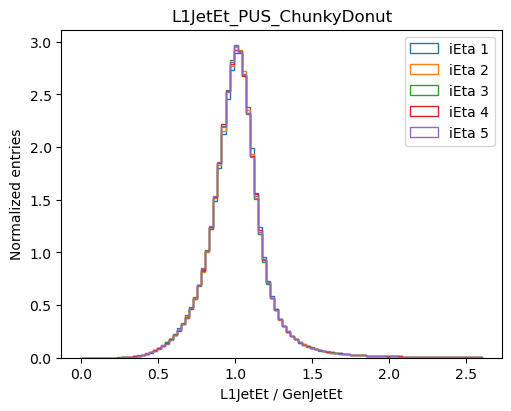

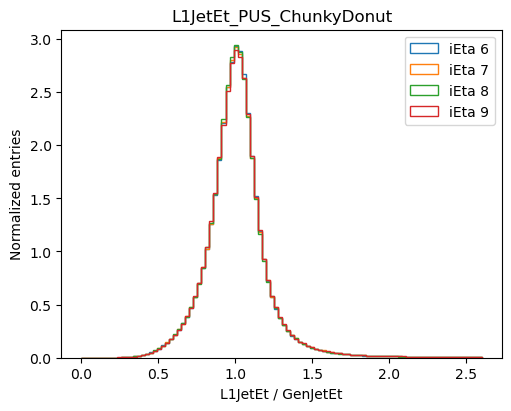

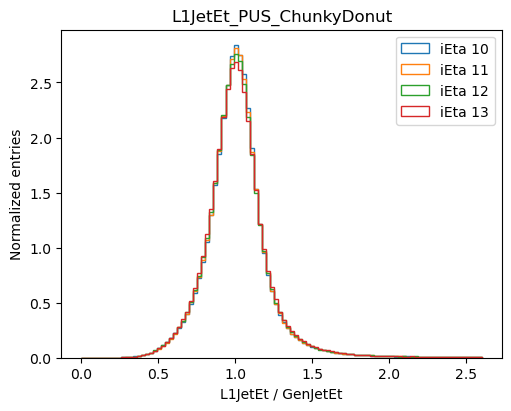

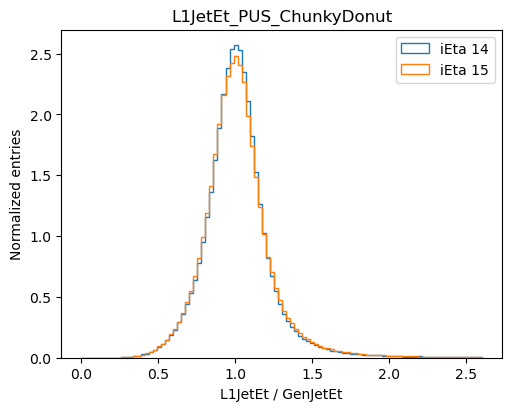

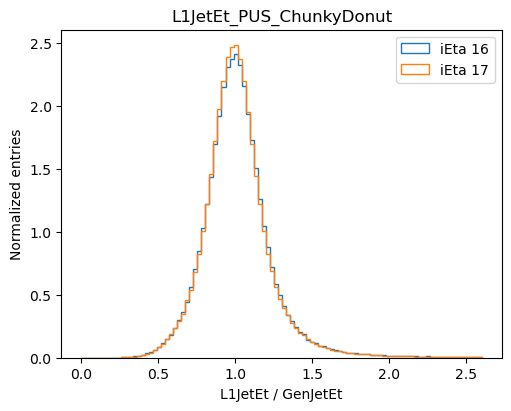

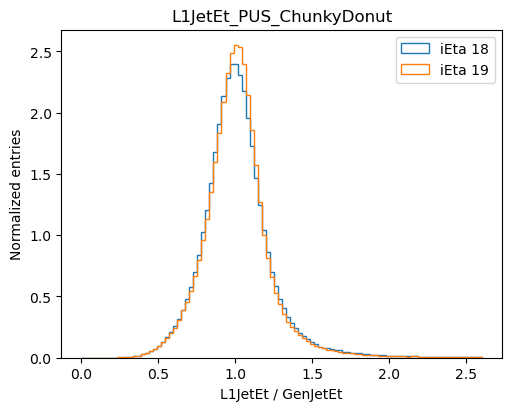

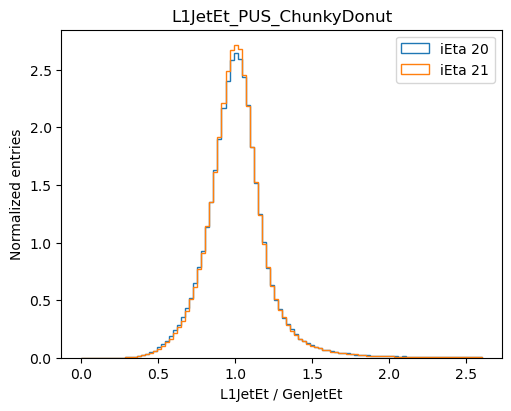

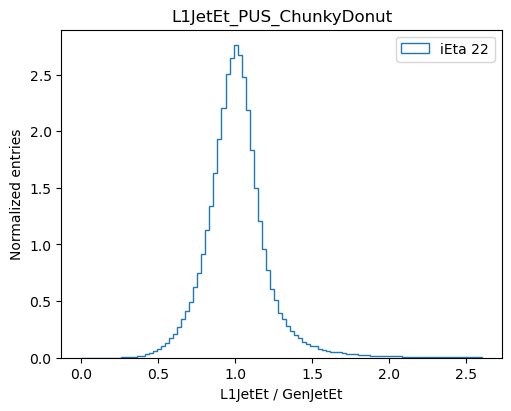

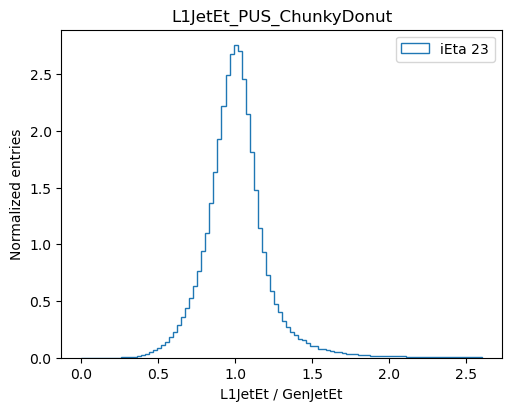

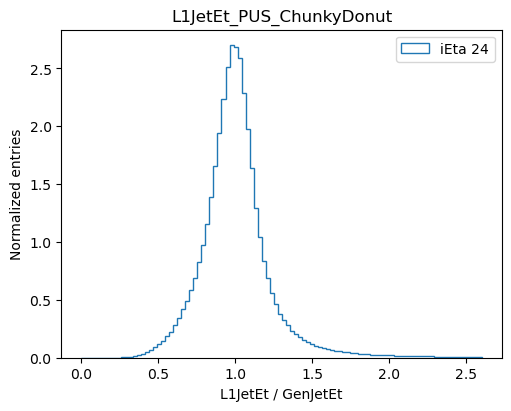

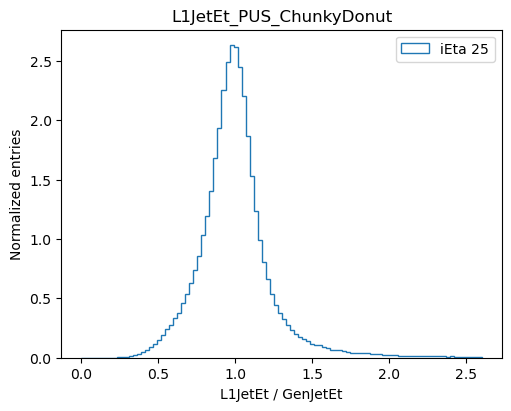

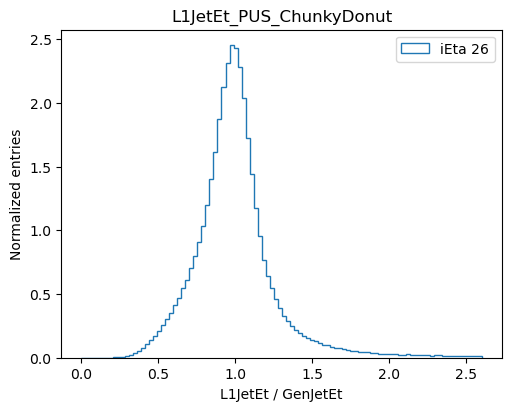

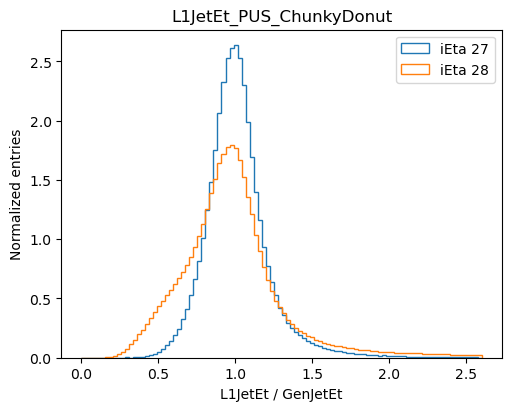

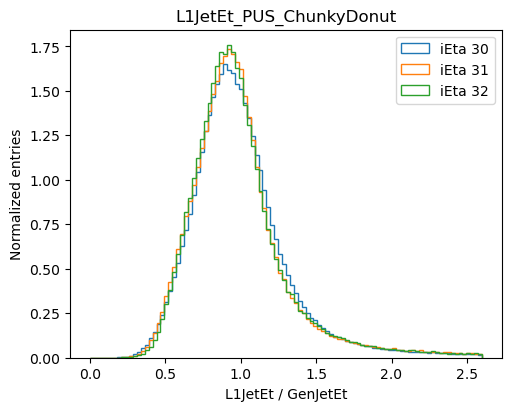

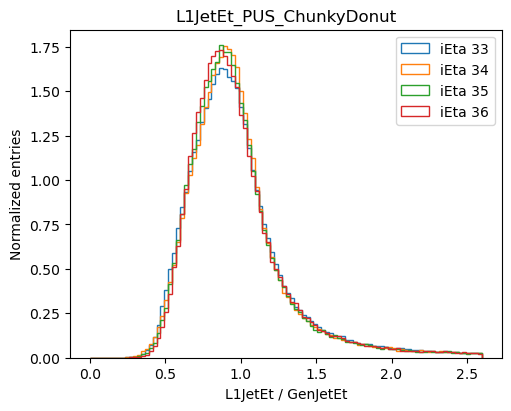

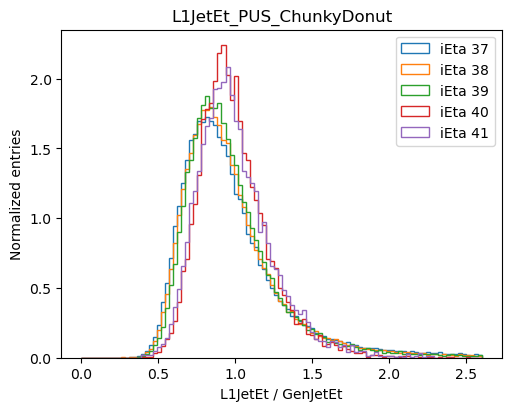

In [11]:
# Resolution plots 
for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    
    for CaloTool_mpEta in CaloToolMPEtaRange: # runs each iEta in iEtaBinRange
        iEtaBin = convert_CaloToolMPEta_to_IEta(CaloTool_mpEta)
        data_copy1_iEtaBin = data_copy1[data_copy1[sL1JetTowerIEtaAbs] == iEtaBin]
        axs.hist(
            (data_copy1_iEtaBin[sL1JetEt_calib]/data_copy1_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='iEta %d' % (iEtaBin),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s' % (sL1JetEt))
    axs.legend()
        
    fig.savefig('%s/AfterJEC_%s_ieta_%d_to_%d.png' % (sOutDir, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))
print("\n\nDone.")



Done.


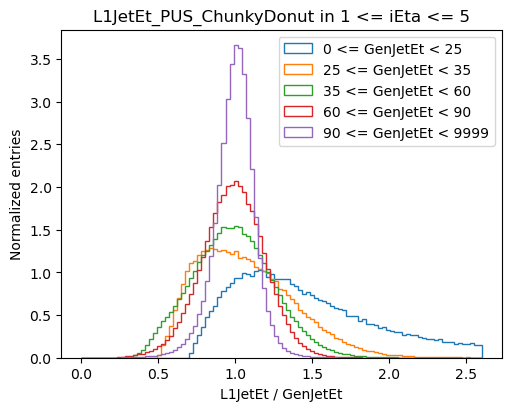

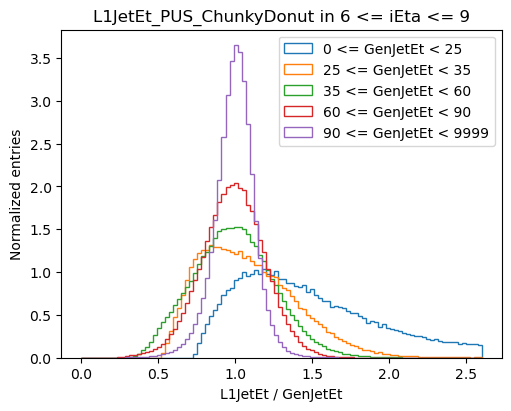

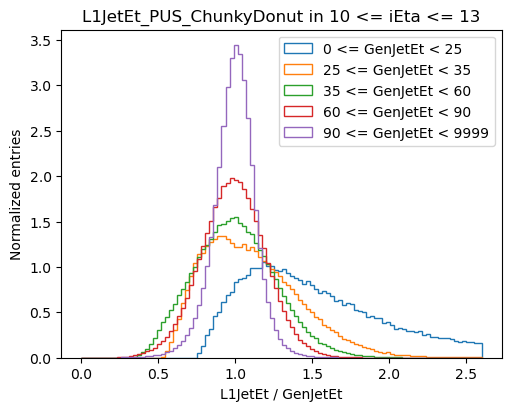

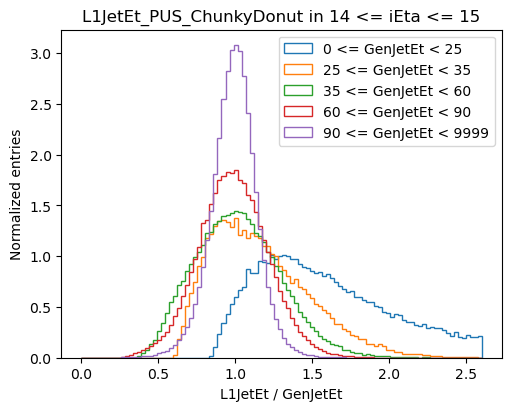

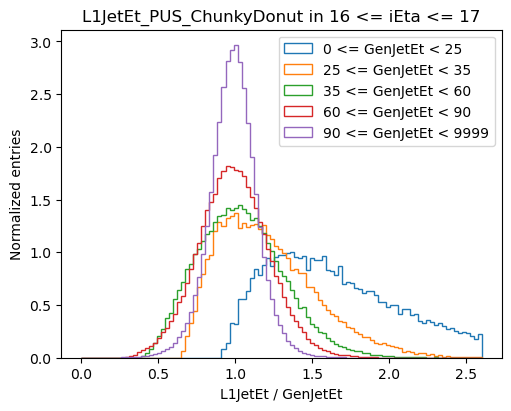

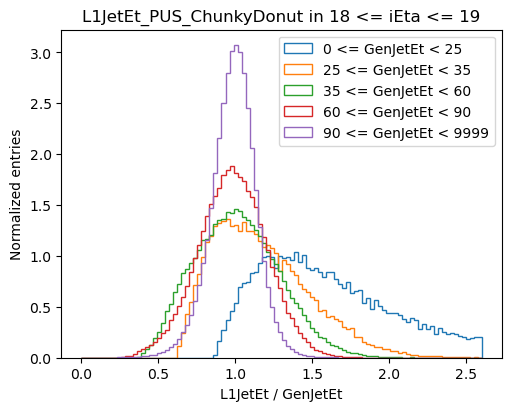

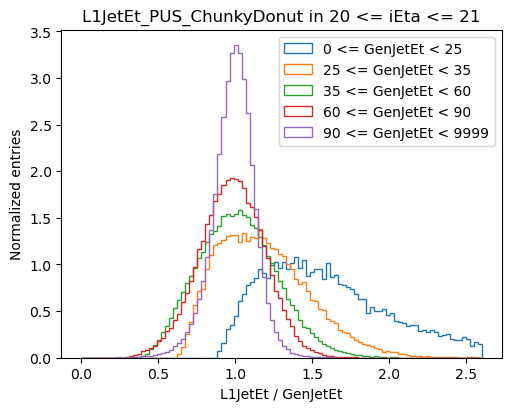

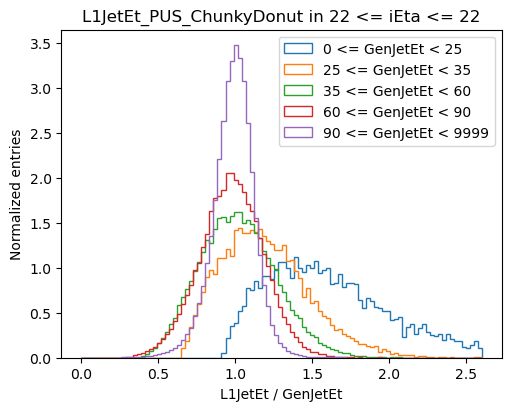

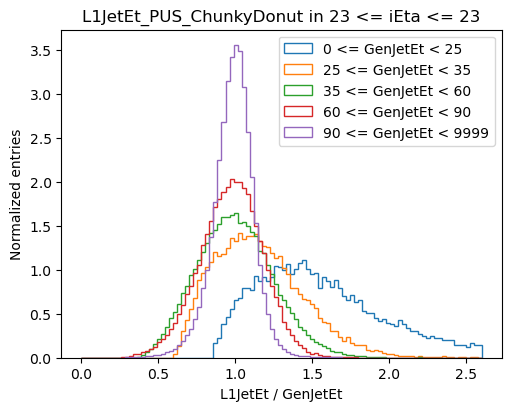

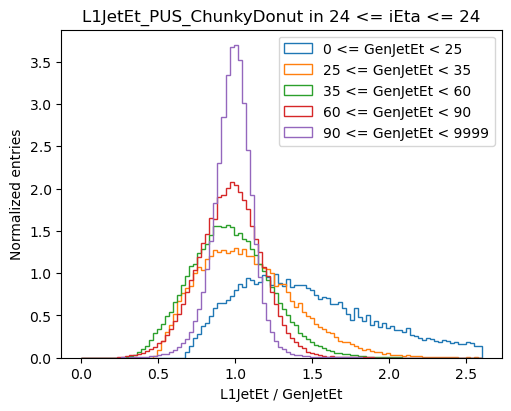

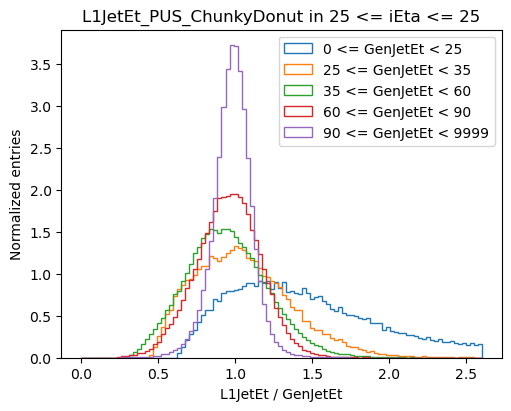

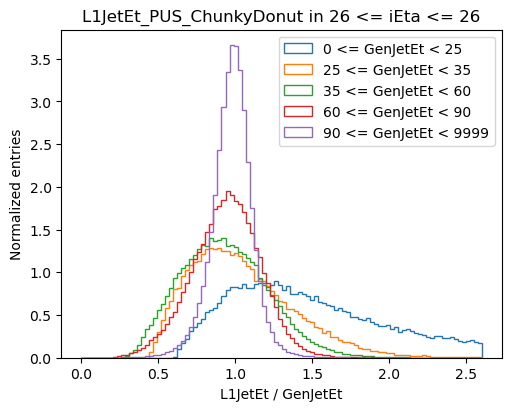

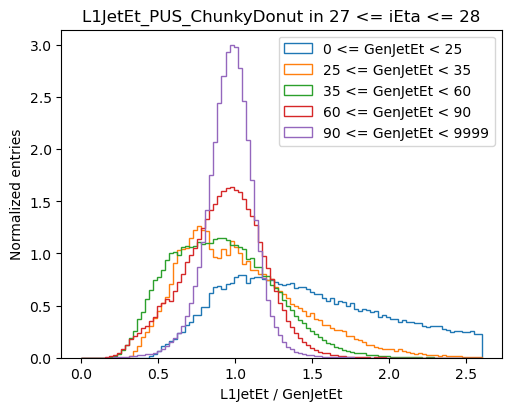

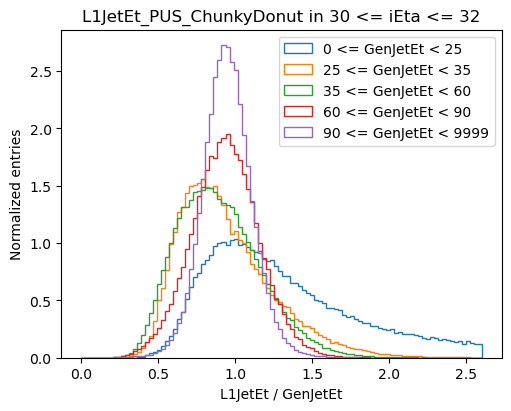

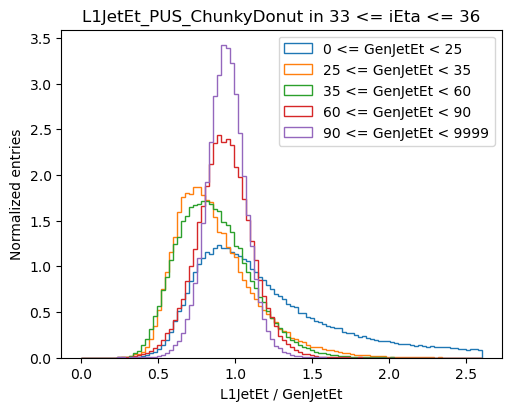

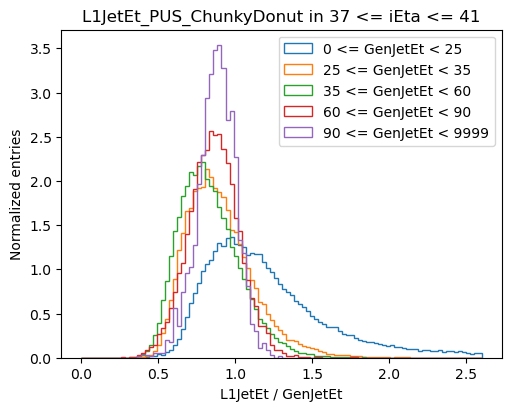

In [12]:

for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    iEtaBin_first = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0])
    iEtaBin_last  = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])
    
    for pt_cat, pt_range in PT_CAT.items(): 
        data_copy1_iEtaBin = data_copy1[ (
            (data_copy1[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
            (data_copy1[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
            (data_copy1[sRefJetEt] >= pt_range[0]) & 
            (data_copy1[sRefJetEt] <  pt_range[2]) )]
        axs.hist(
            (data_copy1_iEtaBin[sL1JetEt_calib]/data_copy1_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='%d <= %s < %d' % (pt_range[0], sRefJetEt, pt_range[2]),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
    axs.legend()
        
    fig.savefig('%s/AfterJEC_%s_ieta_%d_to_%d_inPtCat.png' % (sOutDir, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))
    
print("\n\nDone.")